# Protein Interaction Prediction - Decision Tree Classifier

**Team:** Column Crushers  
**Members:** Connor Fair, Charles Wilson

## Objective
Build a decision tree classifier to predict protein interactions with DNA and RNA using amino acid composition features.

**Classes:**
- DNA: Interacts with DNA
- RNA: Interacts with RNA
- DRNA: Interacts with both DNA and RNA
- nonDRNA: Does not interact with DNA or RNA


## 1. Import Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    matthews_corrcoef,
    classification_report
)

# Set random seed for reproducibility
np.random.seed(42)

#seaborn hue, saturation, lightness colorspace
sns.set_palette("husl")
%matplotlib inline


## 2. Load and Explore Data


In [3]:
# Load training data
data = pd.read_csv('sequences_training.txt', names=['sequence', 'label'])

print(f"Dataset shape: {data.shape}")
print(f"\nFirst few rows:")
data.head()


Dataset shape: (8795, 2)

First few rows:


,sequence,label
0,MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...,nonDRNA
1,MEQKKMKYLENLVGKTPMLELIFDYKGEERRIFVKNESYNLTGSIK...,nonDRNA
2,MTILFQLALAALVILSFVMVIGVPVAYASPQDWDRSKQLIFLGSGL...,nonDRNA
3,MSKIERISAFLNDKEVDMTFITNPTTLNYLTGLAIDPHERIAGLMI...,nonDRNA
4,MSDQQQPPVYKIALGIEYDGSKYYGWQRQNEVRSVQEKLEKALSQV...,RNA


In [4]:
# Check for missing values
print("Missing values:")
print(data.isnull().sum())

# Basic statistics
print(f"\nSequence length statistics:")
data['seq_length'] = data['sequence'].str.len()
print(data['seq_length'].describe())


Missing values:
sequence    0
label       0
dtype: int64

Sequence length statistics:
count    8795.000000
mean      439.155884
std       457.368916
min        30.000000
25%       215.000000
50%       334.000000
75%       499.000000
max      7176.000000
Name: seq_length, dtype: float64


Class distribution:
label
nonDRNA    7859
RNA         523
DNA         391
DRNA         22
Name: count, dtype: int64

Class percentages:
label
nonDRNA    89.357590
RNA         5.946561
DNA         4.445708
DRNA        0.250142
Name: proportion, dtype: float64


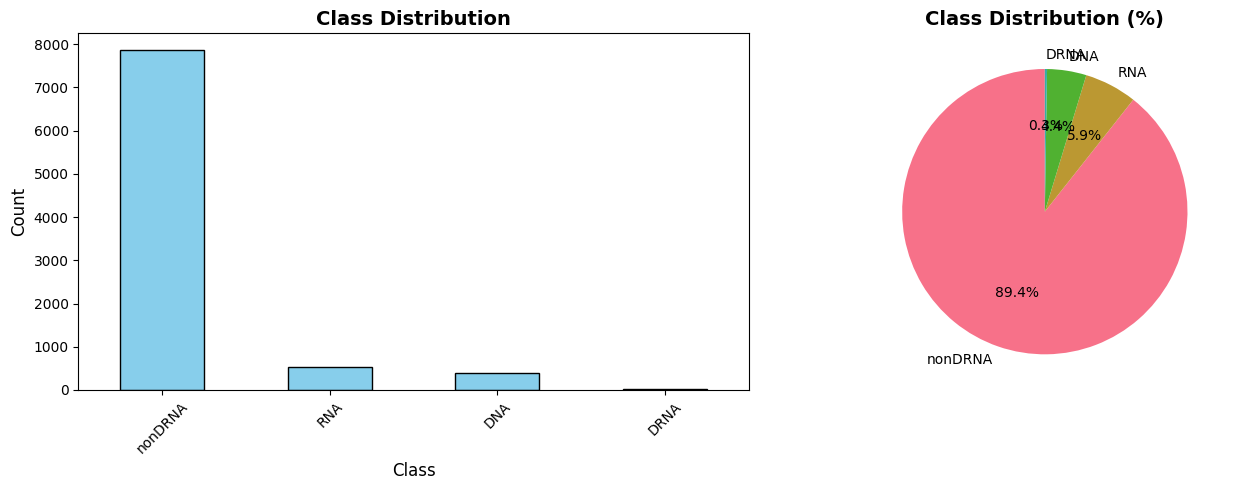


⚠️ Note: Highly imbalanced dataset - DRNA has only 22 samples (0.25%)


In [5]:
# Class distribution
print("Class distribution:")
class_counts = data['label'].value_counts()
print(class_counts)
print(f"\nClass percentages:")
print(data['label'].value_counts(normalize=True) * 100)

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Pie chart
class_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90)
ax2.set_title('Class Distribution (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

print("\n⚠️ Note: Highly imbalanced dataset - DRNA has only 22 samples (0.25%)")


## 3. Feature Extraction - Amino Acid Composition

Extract the frequency of each of the 20 standard amino acids in each protein sequence.


In [6]:
# Standard 20 amino acids
AMINO_ACIDS = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 
               'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def calculate_amino_acid_composition(sequence):
    """
    Calculate the frequency of each amino acid in a protein sequence.
    
    Parameters:
    -----------
    sequence : str
        Protein sequence string
    
    Returns:
    --------
    dict : Dictionary with amino acid frequencies (percentages)
    """
    sequence = sequence.upper()
    seq_length = len(sequence)
    
    if seq_length == 0:
        return {aa: 0.0 for aa in AMINO_ACIDS}
    
    # Count amino acids
    aa_counts = Counter(sequence)
    
    # Calculate frequencies (as percentages)
    composition = {}
    for aa in AMINO_ACIDS:
        composition[aa] = (aa_counts.get(aa, 0) / seq_length) * 100
    
    return composition

# Test the function
test_seq = data.iloc[0]['sequence']
test_comp = calculate_amino_acid_composition(test_seq)
print("Example amino acid composition:")
print(f"Sequence length: {len(test_seq)}")
print(f"Label: {data.iloc[0]['label']}")
print(f"\nComposition (first 5 amino acids):")
for aa in AMINO_ACIDS[:5]:
    print(f"  {aa}: {test_comp[aa]:.2f}%")


Example amino acid composition:
Sequence length: 155
Label: nonDRNA

Composition (first 5 amino acids):
  A: 9.03%
  C: 1.94%
  D: 4.52%
  E: 7.74%
  F: 1.29%


In [7]:
# Extract features for all sequences
print("Extracting amino acid composition features...")
features_list = []

for idx, row in data.iterrows():
    composition = calculate_amino_acid_composition(row['sequence'])
    features_list.append(composition)
    
    if (idx + 1) % 2000 == 0:
        print(f"  Processed {idx + 1}/{len(data)} sequences...")

# Convert to DataFrame
X = pd.DataFrame(features_list)
y = data['label']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeature matrix (first 5 rows, first 5 columns):")
X.head()


Extracting amino acid composition features...
  Processed 2000/8795 sequences...
  Processed 4000/8795 sequences...
  Processed 6000/8795 sequences...
  Processed 8000/8795 sequences...

Feature matrix shape: (8795, 20)
Target vector shape: (8795,)

Feature matrix (first 5 rows, first 5 columns):


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,9.032258,1.935484,4.516129,7.741935,1.290323,9.032258,3.225806,4.516129,7.096774,7.741935,2.580645,4.516129,3.225806,5.161290,6.451613,2.580645,6.451613,5.806452,3.870968,3.225806
1,5.357143,0.595238,5.357143,7.440476,4.166667,8.928571,0.892857,8.630952,11.011905,9.226190,3.571429,5.952381,3.273810,1.190476,2.976190,6.845238,4.166667,6.547619,0.297619,3.571429
2,9.677419,0.000000,3.225806,0.000000,8.064516,6.451613,0.000000,8.064516,1.612903,17.741935,3.225806,1.612903,3.225806,4.838710,1.612903,6.451613,1.612903,17.741935,3.225806,1.612903
3,8.563536,1.104972,7.182320,8.563536,5.248619,7.734807,3.038674,8.287293,5.801105,6.906077,3.591160,4.419890,4.143646,2.209945,3.314917,4.696133,5.524862,6.906077,0.276243,2.486188
4,11.481481,1.111111,5.555556,4.814815,3.333333,5.925926,4.074074,3.703704,4.074074,7.407407,2.222222,4.074074,5.555556,4.444444,7.407407,3.703704,5.185185,9.629630,1.851852,4.444444


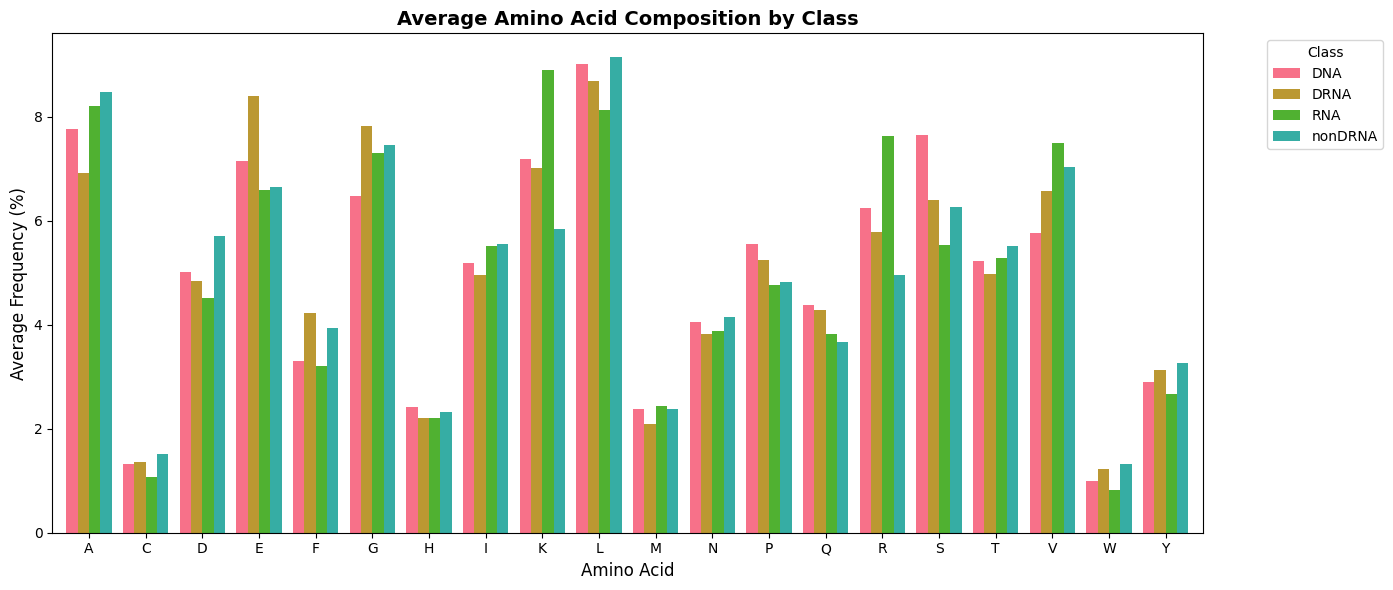

In [8]:
# Visualize average amino acid composition by class
X_with_labels = X.copy()
X_with_labels['label'] = y.values

avg_composition = X_with_labels.groupby('label').mean()

fig, ax = plt.subplots(figsize=(14, 6))
avg_composition.T.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Average Amino Acid Composition by Class', fontsize=14, fontweight='bold')
ax.set_xlabel('Amino Acid', fontsize=12)
ax.set_ylabel('Average Frequency (%)', fontsize=12)
ax.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()


## 4. Decision Tree Model with 5-Fold Cross-Validation


In [9]:
# Initialize Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(
    random_state=42,
    max_depth=None,  # No limit on depth
    min_samples_split=2,
    min_samples_leaf=1
)

print("Decision Tree Classifier initialized with parameters:")
print(dt_classifier.get_params())


Decision Tree Classifier initialized with parameters:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


In [10]:
# Perform 5-fold stratified cross-validation
print("Performing 5-fold stratified cross-validation...\n")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get predictions using cross-validation
y_pred = cross_val_predict(dt_classifier, X, y, cv=skf)

print("Cross-validation complete!")
print(f"Predictions shape: {y_pred.shape}")


Performing 5-fold stratified cross-validation...

Cross-validation complete!
Predictions shape: (8795,)


## 5. Evaluation Metrics

Calculate Sensitivity, Specificity, Accuracy, and MCC for each class.


In [11]:
def calculate_metrics_per_class(y_true, y_pred, classes):
    """
    Calculate Sensitivity, Specificity, and MCC for each class.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    classes : list
        List of class labels
    
    Returns:
    --------
    pd.DataFrame : Metrics for each class
    """
    metrics = []
    
    for cls in classes:
        # Binary classification: current class vs all others
        y_true_binary = (y_true == cls).astype(int)
        y_pred_binary = (y_pred == cls).astype(int)
        
        # Confusion matrix elements
        tn = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
        tp = np.sum((y_true_binary == 1) & (y_pred_binary == 1))
        fn = np.sum((y_true_binary == 1) & (y_pred_binary == 0))
        fp = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
        
        # Calculate metrics
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        
        # MCC
        mcc = matthews_corrcoef(y_true_binary, y_pred_binary)
        
        metrics.append({
            'Class': cls,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Accuracy': accuracy,
            'MCC': mcc,
            'Support': np.sum(y_true_binary)
        })
    
    return pd.DataFrame(metrics)

# Calculate metrics
classes = ['DNA', 'RNA', 'DRNA', 'nonDRNA']
metrics_df = calculate_metrics_per_class(y, y_pred, classes)

print("\n" + "="*80)
print("PERFORMANCE METRICS PER CLASS")
print("="*80)
print(metrics_df.to_string(index=False))
print("="*80)



PERFORMANCE METRICS PER CLASS
  Class  Sensitivity  Specificity  Accuracy      MCC  Support
    DNA     0.235294     0.957877  0.925753 0.181464      391
    RNA     0.386233     0.956359  0.922456 0.330999      523
   DRNA     0.045455     0.997264  0.994883 0.040081       22
nonDRNA     0.919455     0.428419  0.867197 0.333062     7859


In [12]:
# Overall metrics
overall_accuracy = accuracy_score(y, y_pred)
average_mcc = metrics_df['MCC'].mean()

print("\n" + "="*80)
print("OVERALL METRICS")
print("="*80)
print(f"4-Label Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"Average MCC:      {average_mcc:.4f}")
print("="*80)



OVERALL METRICS
4-Label Accuracy: 0.8551 (85.51%)
Average MCC:      0.2214


In [13]:
# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y, y_pred, target_names=classes, digits=4))



Detailed Classification Report:
              precision    recall  f1-score   support

         DNA     0.2063    0.2353    0.2198       391
         RNA     0.0400    0.0455    0.0426        22
        DRNA     0.3588    0.3862    0.3720       523
     nonDRNA     0.9311    0.9195    0.9252      7859

    accuracy                         0.8551      8795
   macro avg     0.3840    0.3966    0.3899      8795
weighted avg     0.8626    0.8551    0.8588      8795



## 6. Visualizations


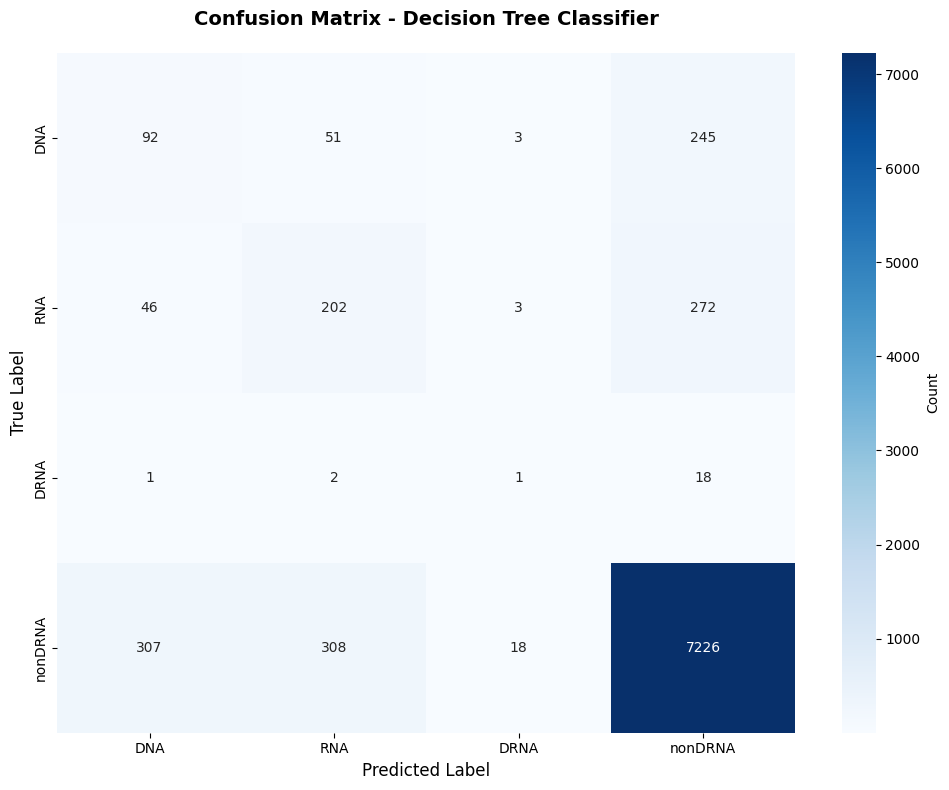

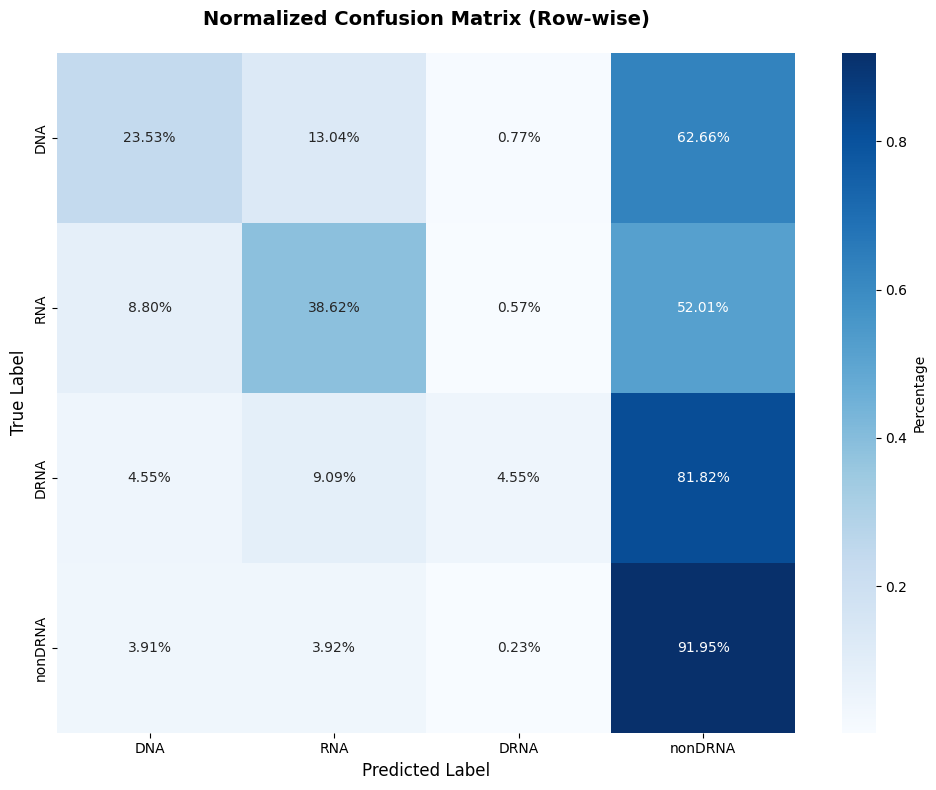

In [14]:
# Confusion Matrix
cm = confusion_matrix(y, y_pred, labels=classes)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'}, ax=ax)
ax.set_title('Confusion Matrix - Decision Tree Classifier', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Percentage'}, ax=ax)
ax.set_title('Normalized Confusion Matrix (Row-wise)', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()


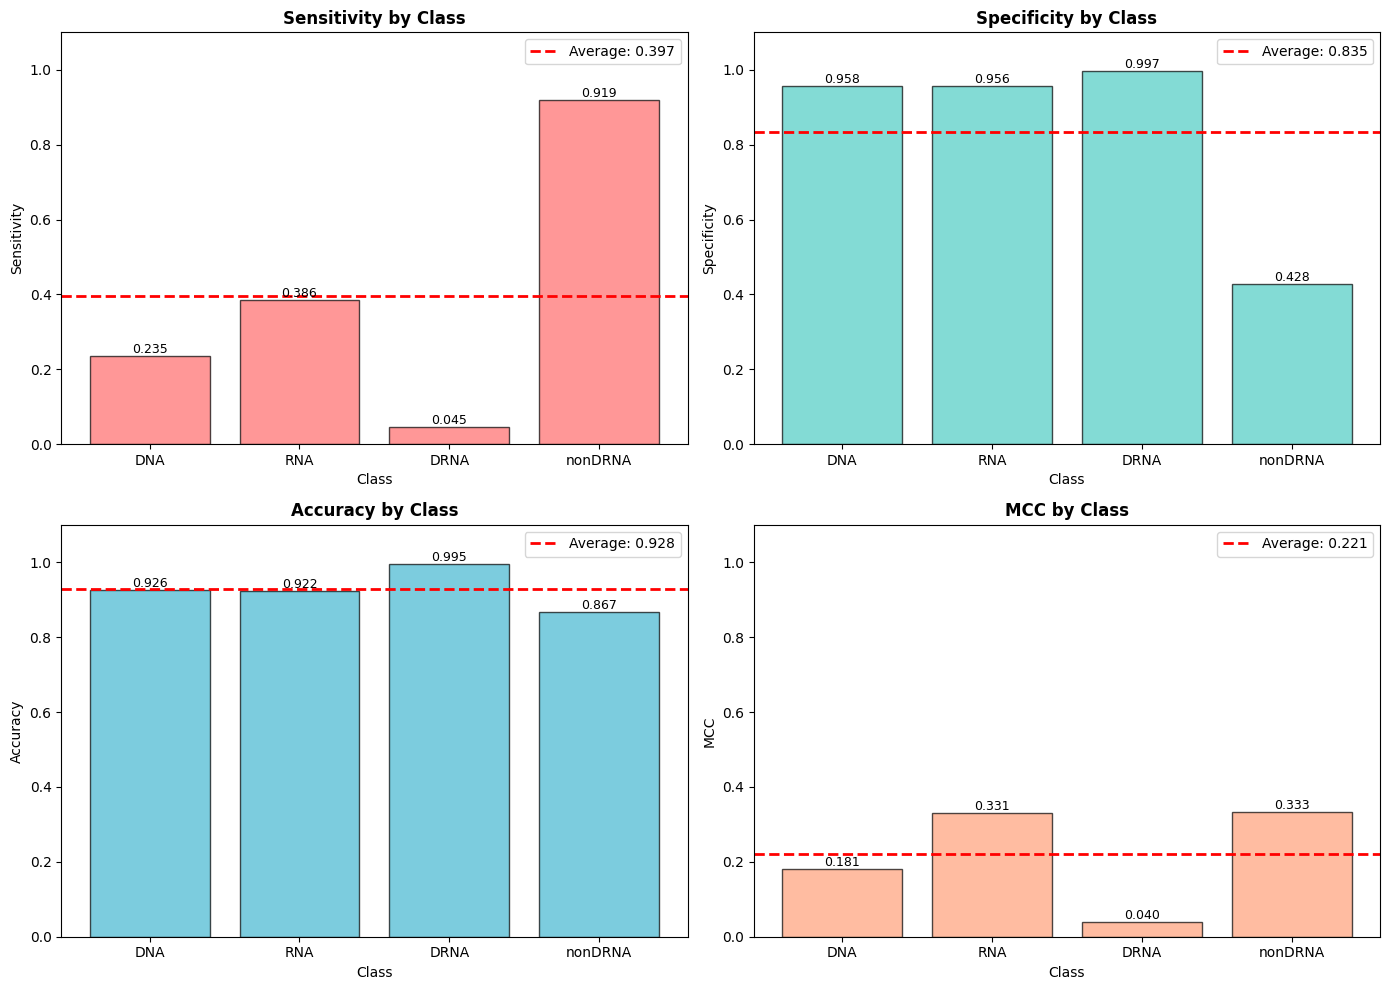

In [15]:
# Performance metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['Sensitivity', 'Specificity', 'Accuracy', 'MCC']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(metrics_df['Class'], metrics_df[metric], color=color, edgecolor='black', alpha=0.7)
    ax.set_title(f'{metric} by Class', fontsize=12, fontweight='bold')
    ax.set_xlabel('Class', fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.set_ylim([0, 1.1])
    ax.axhline(y=metrics_df[metric].mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Average: {metrics_df[metric].mean():.3f}')
    ax.legend()
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



Top 10 Most Important Amino Acids:
Amino Acid  Importance
         K    0.137888
         R    0.137248
         E    0.071555
         G    0.058526
         S    0.054425
         V    0.048775
         C    0.040713
         T    0.039979
         P    0.039624
         D    0.038598


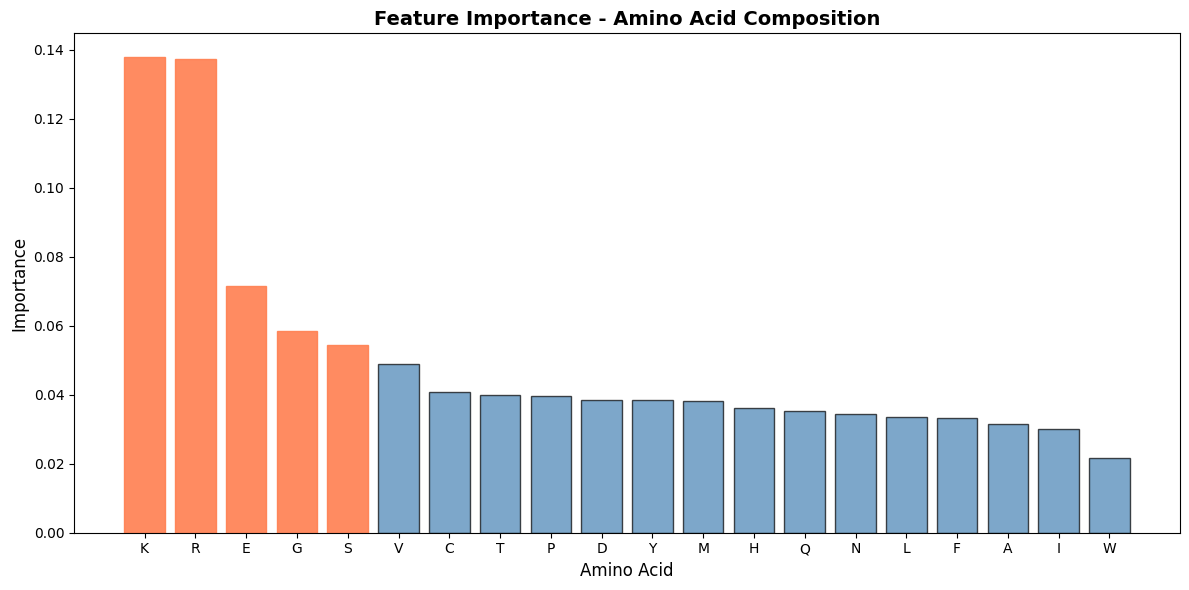

In [16]:
# Train final model on full dataset to get feature importances
dt_classifier.fit(X, y)

# Feature importance
feature_importance = pd.DataFrame({
    'Amino Acid': AMINO_ACIDS,
    'Importance': dt_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Amino Acids:")
print(feature_importance.head(10).to_string(index=False))

# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(feature_importance['Amino Acid'], feature_importance['Importance'], 
              color='steelblue', edgecolor='black', alpha=0.7)
ax.set_title('Feature Importance - Amino Acid Composition', fontsize=14, fontweight='bold')
ax.set_xlabel('Amino Acid', fontsize=12)
ax.set_ylabel('Importance', fontsize=12)
ax.tick_params(axis='x', rotation=0)

# Highlight top 5
top_5_aa = feature_importance.head(5)['Amino Acid'].values
for i, bar in enumerate(bars):
    if feature_importance.iloc[i]['Amino Acid'] in top_5_aa:
        bar.set_color('coral')
        bar.set_alpha(0.9)

plt.tight_layout()
plt.show()


## 7. Summary and Insights


In [17]:
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"Model: Decision Tree Classifier")
print(f"Features: Amino Acid Composition (20 features)")
print(f"Cross-Validation: 5-Fold Stratified")
print(f"Training Samples: {len(y)}")
print(f"\nClass Distribution:")
for cls in classes:
    count = np.sum(y == cls)
    print(f"  {cls:8s}: {count:5d} ({count/len(y)*100:5.2f}%)")
print(f"\nOverall Performance:")
print(f"  4-Label Accuracy: {overall_accuracy:.4f}")
print(f"  Average MCC:      {average_mcc:.4f}")
print(f"\nPer-Class Performance:")
for _, row in metrics_df.iterrows():
    print(f"  {row['Class']:8s}: SENS={row['Sensitivity']:.3f}, SPEC={row['Specificity']:.3f}, MCC={row['MCC']:.3f}")
print(f"\nTop 3 Important Features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"  {i+1}. {row['Amino Acid']}: {row['Importance']:.4f}")
print("="*80)



SUMMARY
Model: Decision Tree Classifier
Features: Amino Acid Composition (20 features)
Cross-Validation: 5-Fold Stratified
Training Samples: 8795

Class Distribution:
  DNA     :   391 ( 4.45%)
  RNA     :   523 ( 5.95%)
  DRNA    :    22 ( 0.25%)
  nonDRNA :  7859 (89.36%)

Overall Performance:
  4-Label Accuracy: 0.8551
  Average MCC:      0.2214

Per-Class Performance:
  DNA     : SENS=0.235, SPEC=0.958, MCC=0.181
  RNA     : SENS=0.386, SPEC=0.956, MCC=0.331
  DRNA    : SENS=0.045, SPEC=0.997, MCC=0.040
  nonDRNA : SENS=0.919, SPEC=0.428, MCC=0.333

Top 3 Important Features:
  9. K: 0.1379
  15. R: 0.1372
  4. E: 0.0716


## 8. Next Steps

Potential improvements to explore:

1. **Feature Engineering:**
   - Add k-mer features (2-mers, 3-mers)
   - Include sequence length as a feature
   - Add physicochemical properties (hydrophobicity, charge, etc.)

2. **Model Tuning:**
   - Hyperparameter optimization (max_depth, min_samples_split, etc.)
   - Try different splitting criteria (gini vs entropy)

3. **Handle Class Imbalance:**
   - Use class weights
   - SMOTE or other resampling techniques
   - Focus on improving DRNA prediction (only 22 samples)

4. **Try Other Models:**
   - Random Forest (ensemble of decision trees)
   - Support Vector Machines
   - Neural Networks

5. **Analysis:**
   - Visualize decision tree structure
   - Analyze misclassified samples
   - Feature correlation analysis
